Idea for varying a math problem each time it is solved by the user. This relies on an Anki addon I've prototyped that provides each card a "random seed" that changes if and only if the card is solved, i.e., the user clicks the "easy" or "good" button, and possibly the "hard" button.

Note I'm using the random seed directly rather than seeding and using an actual random number generator.

### `Front` and `Back` templates are setup like so:

`Front` template:

```html
<script>
  // Avoid redefining random seed variable.
  if (typeof random_seed === 'undefined') { let random_seed; }
  // Initialize random seed.
  if (`{{randseed-Seed:}}`.startsWith('Unknown field:')) {
    // If custom field isn't available, default to zero.
    random_seed = 0;
  } else {
    random_seed = {{randseed-Seed:}};
  }

  // Run JavaScript snippet from card to interpolate random
  // params for displaying front and back sides.
  {{Params}}

  // Copy raw interpolated Front to div below.
  document.getElementById('parameterized_front').innerHTML = String.raw`{{Front}}`;
</script>

<div id='parameterized_front'>
  (Warning: Front not yet defined by card template script.)
</div>
```

`Back` template:

```html

{{FrontSide}}

<hr id=answer>

<script>
  // Random seed and params have  already been setup in Front  template.
  // Copy raw interpolated Back to div below.
  document.getElementById('parameterized_back').innerHTML = String.raw`{{Back}}`;
</script>

<div id='parameterized_back'>
  (Warning: Back not yet defined by card template script.)
</div>
```

### And Anki card using the above template are setup like so:

Example card `Params` field:

```javascript
// Example:
if (typeof params === 'undefined') { let params, a, b; }
params = [
  [1,2],
  [1,4],
  [2,3],
];
[a, b] = params[random_seed % params.length];
```

Variant with full expression:

```javascript
if (typeof params === 'undefined') { let params, a, ex; }
random_seed = 2;
params = [
  [2, String.raw`\left(z^{2} - 2 z + 2\right) e^{z}`],
  [3, String.raw`\left(z^{3} - 3 z^{2} + 6 z - 6\right) e^{z}`],
  [4, String.raw`\left(z^{4} - 4 z^{3} + 12 z^{2} - 24 z + 24\right) e^{z}`],
  [5, String.raw`\left(z^{5} - 5 z^{4} + 20 z^{3} - 60 z^{2} + 120 z - 120\right) e^{z}`],
];
[a, ex] = params[random_seed % params.length];
```

Example card `Front` field:

```latex
\[
\int_{${a}}^{${b}} w^2 \ln w \,dw
\]
```

Similarly for `Back` field. Note `a` and `b` are interpolated when card is displayed.

In [2]:
import sympy as sy
from sympy import sympify as sfy
from IPython import display
from fractions import Fraction as R
import itertools, functools

In [3]:
a,b,c,d,e,s,t,u,v,w,x,y,z,theta = sy.symbols('a,b,c,d,e,s,t,u,v,w,x,y,z,theta')

In [28]:
def _generate_variable_value_pairs(variable, values):
    return ((variable, value) for value in values)

def _generate_variable_value_pair_lists(params):
    return (_generate_variable_value_pairs(variable, values) for (variable, values) in params.items())

def generate_args_lists(params):
    return itertools.product(*_generate_variable_value_pair_lists(params))

def _subs_one_item(ex, item):
    return ex.subs(*item)

def subs_items(ex, args_list):
    return functools.reduce(
        _subs_one_item,
        args_list,
        ex
    )

def extract_variables(args_list):
    return (var for (var, val) in args_list)

def extract_values(args_list):
    return (val for (var, val) in args_list)

def filter_args_lists(args_lists, filter_func = None):
    if filter_func is None:
        return args_lists
    return filter(lambda args_list: filter_func(*extract_values(args_list)), args_lists)

def get_params_script(
    ex,
    params,
    show_vars = True, show_prob = True, show_sol = True,
    filter_func = None,
    pre_func = None, post_func = None
):
    if not (show_vars or show_prob or show_sol):
        raise Exception("at least one of show_vars or show_prob or show_sol should be True")
    script_lines = []
    variables = params.keys()
    vars_str = f",{','.join(str(var) for var in params.keys())}" if show_vars else ""
    prob_var_str = ",prob" if show_prob else ""
    sol_var_str = ",sol" if show_sol else ""
    params_str = f"params{vars_str}{prob_var_str}{sol_var_str}"
    script_lines.append(f"if (typeof params === 'undefined') {{ let {params_str}; }}")
    script_lines.append("params = [")
    for args_list in filter_args_lists(generate_args_lists(params), filter_func):
        vals_str = f"{','.join(str(val) for val in extract_values(args_list))}," if show_vars else ""
        prob = subs_items(ex, args_list)
        prob = pre_func(prob) if pre_func else prob
        prob_str = f"String.raw`{sy.latex(prob)}`," if show_prob else ""
        sol = prob.doit()
        sol = post_func(sol) if post_func else sol
        sol_str = f"String.raw`{sy.latex(sol)}`," if show_sol else ""
        script_lines.append(f"  [{vals_str}{prob_str}{sol_str}],")
    script_lines.append("];")
    script_lines.append("//random_seed=0;")
    script_lines.append(f"[{params_str.split(',',1)[-1]}] = params[random_seed % params.length];")
    return '\n'.join(script_lines)

### Example params script:

In [310]:
ex = sy.Integral(1/(c - d*x)**2, (x, a, b))
ex

Integral((c - d*x)**(-2), (x, a, b))

In [313]:
params = {
    a: range(4),
    b: range(1,8),
    c: range(1,4),
    d: range(1,8),
}

In [340]:
filter_func = lambda a,b,c,d: (a<b) and (c<d)

In [10]:
param_script = get_params_script(ex, params, filter_func)

NameError: name 'filter_func' is not defined

In [346]:
print(param_script)

if (typeof params === 'undefined') { let params,a,b,c,d,prob,sol; }
params = [
  [0,1,1,1,String.raw`\int\limits_{0}^{1} \frac{1}{\left(1 - x\right)^{2}}\, dx`,String.raw`\infty`,],
  [0,1,1,2,String.raw`\int\limits_{0}^{1} \frac{1}{\left(1 - 2 x\right)^{2}}\, dx`,String.raw`\infty`,],
  [0,1,1,3,String.raw`\int\limits_{0}^{1} \frac{1}{\left(1 - 3 x\right)^{2}}\, dx`,String.raw`\infty`,],
  [0,1,1,4,String.raw`\int\limits_{0}^{1} \frac{1}{\left(1 - 4 x\right)^{2}}\, dx`,String.raw`\infty`,],
  [0,1,1,5,String.raw`\int\limits_{0}^{1} \frac{1}{\left(1 - 5 x\right)^{2}}\, dx`,String.raw`\infty`,],
  [0,1,1,6,String.raw`\int\limits_{0}^{1} \frac{1}{\left(1 - 6 x\right)^{2}}\, dx`,String.raw`\infty`,],
  [0,1,1,7,String.raw`\int\limits_{0}^{1} \frac{1}{\left(1 - 7 x\right)^{2}}\, dx`,String.raw`\infty`,],
  [0,1,2,1,String.raw`\int\limits_{0}^{1} \frac{1}{\left(2 - x\right)^{2}}\, dx`,String.raw`\frac{1}{2}`,],
  [0,1,2,2,String.raw`\int\limits_{0}^{1} \frac{1}{\left(2 - 2 x\right)^{2}}\, d

### CET 5.5 xm 8:

In [79]:
prob = sy.Integral(1/(c - d*x)**2, (x, a, b))
prob

Integral((c - d*x)**(-2), (x, a, b))

In [80]:
sol = prob.doit()
sol

-1/(b*d**2 - c*d) + 1/(a*d**2 - c*d)

In [81]:
sol.subs(a,_a).subs(b,_b).subs(c,_c).subs(d,_d)

1/165

In [82]:
for _a in range(4):
    for _b in range(1,4):
        _b += _a
        for _c in range(1,4):
            for _d in range(1,4):
                _d += _c
                _sol = sol.subs(a,_a).subs(b,_b).subs(c,_c).subs(d,_d)
                print(f"  [{_a},{_b},{_c},{_d},String.raw`{sy.latex(_sol)}`],")

  [0,1,1,2,String.raw`-1`],
  [0,1,1,3,String.raw`- \frac{1}{2}`],
  [0,1,1,4,String.raw`- \frac{1}{3}`],
  [0,1,2,3,String.raw`- \frac{1}{2}`],
  [0,1,2,4,String.raw`- \frac{1}{4}`],
  [0,1,2,5,String.raw`- \frac{1}{6}`],
  [0,1,3,4,String.raw`- \frac{1}{3}`],
  [0,1,3,5,String.raw`- \frac{1}{6}`],
  [0,1,3,6,String.raw`- \frac{1}{9}`],
  [0,2,1,2,String.raw`- \frac{2}{3}`],
  [0,2,1,3,String.raw`- \frac{2}{5}`],
  [0,2,1,4,String.raw`- \frac{2}{7}`],
  [0,2,2,3,String.raw`- \frac{1}{4}`],
  [0,2,2,4,String.raw`- \frac{1}{6}`],
  [0,2,2,5,String.raw`- \frac{1}{8}`],
  [0,2,3,4,String.raw`- \frac{2}{15}`],
  [0,2,3,5,String.raw`- \frac{2}{21}`],
  [0,2,3,6,String.raw`- \frac{2}{27}`],
  [0,3,1,2,String.raw`- \frac{3}{5}`],
  [0,3,1,3,String.raw`- \frac{3}{8}`],
  [0,3,1,4,String.raw`- \frac{3}{11}`],
  [0,3,2,3,String.raw`- \frac{3}{14}`],
  [0,3,2,4,String.raw`- \frac{3}{20}`],
  [0,3,2,5,String.raw`- \frac{3}{26}`],
  [0,3,3,4,String.raw`- \frac{1}{9}`],
  [0,3,3,5,String.raw`- \frac

### 5.5 xm 5:

In [83]:
prob = sy.Integral(sy.sqrt(a + x**2) * x**b, x)
prob

Integral(x**b*sqrt(a + x**2), x)

In [95]:
prob.subs(a,1).subs(b,5)

Integral(x**5*sqrt(x**2 + 1), x)

In [155]:
display.display_latex(prob)
display.display_latex(prob)


In [97]:
prob.subs(a,1).subs(b,5).doit().factor()

(x**2 + 1)**(3/2)*(15*x**4 - 12*x**2 + 8)/105

In [ ]:
print("if (typeof params === 'undefined') { let params, a, b; }")
print("params = [")
for _a in range(1,3):
    for _b in range(1,3):
        _b = 1 + 2*_b
        _prob = prob.subs(a,_a).subs(b,_b)
        _sol = _prob.doit().simplify()
        print(f"  [{_a},{_b},String.raw`{sy.latex(_prob)}`,String.raw`{sy.latex(_sol)}`],")
print("];")
print("[a,b,prob,sol,] = params[random_seed % params.length];")

### CET 7.4 xc 6:

In [159]:
_u = (a*x-b)
denom = _u**2 + c
num = denom + (d*x - e)
prob = sy.Integral(num.expand()/denom.expand(), x)
prob

Integral((a**2*x**2 - 2*a*b*x + b**2 + c + d*x - e)/(a**2*x**2 - 2*a*b*x + b**2 + c), x)

In [160]:
prob.subs(a,2).subs(b,1).subs(c,2).subs(d,1).subs(e,1)

Integral((4*x**2 - 3*x + 2)/(4*x**2 - 4*x + 3), x)

In [ ]:
print("if (typeof params === 'undefined') { let params, prob, sol; }")
print("params = [")
for _a in range(1,4):
    for _b in range(1,3):
        for _c in range(1,3):
            for _d in range(1,3):
                for _e in range(1,3):
                    _prob = prob.subs(a,_a).subs(b,_b).subs(c,_c).subs(d,_d).subs(e,_e)
                    _sol = _prob.doit().simplify()
                    #display.display_latex(_prob)
                    #display.display_latex(_sol)
                    print(f"  [String.raw`{sy.latex(_prob)}`,String.raw`{sy.latex(_sol)} + C`],")
print("];")
print("[prob,sol,] = params[random_seed % params.length];")


<div class="container">
  <div class="row">
    <div class="col-md-12 twelve columns">

<p>For \</p><p>For <anki-mathjax>z^3</anki-mathjax>:</p><p>First let <span class="math"><anki-mathjax>u=z^{3}, d v=e^{z} d z</anki-mathjax></span> <span class="math"><anki-mathjax>\Rightarrow d u=3 z^{2} d z, v=e^{z} .</anki-mathjax></span> Then <span class="math"><anki-mathjax>I_{1}=\int z^{3} e^{z} d z</anki-mathjax></span> <span class="math"><anki-mathjax>=z^{3} e^{z}-3 \int z^{2} e^{z} d z .</anki-mathjax></span> Next let <span class="math"><anki-mathjax>u_{1}=z^{2},</anki-mathjax></span> <span class="math"><anki-mathjax>d v_{1}=e^{z} d z</anki-mathjax></span> <span class="math"><anki-mathjax>\Rightarrow d u_{1}=2 z d z, v_{1}</anki-mathjax></span> <span class="math"><anki-mathjax>=e^{z} \cdot</anki-mathjax></span> Then <span class="math"><anki-mathjax>I_{2}=z^{2} e^{z}-2 \int z e^{z} d z .</anki-mathjax></span> Finally, let <span class="math"><anki-mathjax>u_{2}=z, d v_{2}=e^{z} d z</anki-mathjax></span> <span class="math"><anki-mathjax>\Rightarrow d u_{2}=d z,</anki-mathjax></span> <span class="math"><anki-mathjax>v_{2}</anki-mathjax></span> <span class="math"><anki-mathjax>=e^{z} \cdot</anki-mathjax></span> Then <span class="math"><anki-mathjax>\int z e^{z} d z</anki-mathjax></span> <span class="math"><anki-mathjax>=z e^{z}-\int e^{z} d z</anki-mathjax></span> <span class="math"><anki-mathjax>=z e^{z}-e^{z}+C_{1} .</anki-mathjax></span> Substituting in the expression for <span class="math"><anki-mathjax>I_{2},</anki-mathjax></span> we get <span class="math"><anki-mathjax>I_{2}=z^{2} e^{z}-2\left(z e^{z}-e^{z}+C_{1}\right)</anki-mathjax></span> <span class="math"><anki-mathjax>=z^{2} e^{z}-2 z e^{z}+2 e^{z}-2 C_{1} .</anki-mathjax></span> Substituting the last expression for <span class="math"><anki-mathjax>I_{2}</anki-mathjax></span> into <span class="math"><anki-mathjax>I_{1}</anki-mathjax></span> gives <span class="math"><anki-mathjax>I_{1}=z^{3} e^{z}-3\left(z^{2} e^{z}-2 z e^{z}+2 e^{z}-2 C_{1}\right)</anki-mathjax></span> <span class="math"><anki-mathjax>=z^{3} e^{z}-3 z^{2} e^{z}+6 z e^{z}-6 e^{z}+C,</anki-mathjax></span> where <span class="math"><anki-mathjax>C=6 C_{1}.</anki-mathjax></span></p>

      </div>
  </div>
</div>


### CET 7.3 xs 12:

In [15]:
_prob = sy.Integral(1/sy.sqrt(a**2 + t**2), (t, 0, a))
print(sy.latex(_prob))
_prob

\int\limits_{0}^{a} \frac{1}{\sqrt{a^{2} + t^{2}}}\, dt


Integral(1/sqrt(a**2 + t**2), (t, 0, a))

In [21]:
print("if (typeof parameters === 'undefined') { let parameters,a,problem,solution; }")
print("parameters = [")
for _a in range(2,10):
    prob=_prob.subs(a, _a)
    sol = prob.doit()
    print(f'  [{_a}, String.raw`{sy.latex(prob)}`,String.raw`{sy.latex(sol)}`],')
print("];")
print("//random_seed=0;")
print("[a, problem, solution] = parameters[random_seed % parameters.length];")

if (typeof parameters === 'undefined') { let parameters,a,problem,solution; }
parameters = [
  [2, String.raw`\int\limits_{0}^{2} \frac{1}{\sqrt{t^{2} + 4}}\, dt`,String.raw`\log{\left(1 + \sqrt{2} \right)}`],
  [3, String.raw`\int\limits_{0}^{3} \frac{1}{\sqrt{t^{2} + 9}}\, dt`,String.raw`\log{\left(1 + \sqrt{2} \right)}`],
  [4, String.raw`\int\limits_{0}^{4} \frac{1}{\sqrt{t^{2} + 16}}\, dt`,String.raw`\log{\left(1 + \sqrt{2} \right)}`],
  [5, String.raw`\int\limits_{0}^{5} \frac{1}{\sqrt{t^{2} + 25}}\, dt`,String.raw`\log{\left(1 + \sqrt{2} \right)}`],
  [6, String.raw`\int\limits_{0}^{6} \frac{1}{\sqrt{t^{2} + 36}}\, dt`,String.raw`\log{\left(1 + \sqrt{2} \right)}`],
  [7, String.raw`\int\limits_{0}^{7} \frac{1}{\sqrt{t^{2} + 49}}\, dt`,String.raw`\log{\left(1 + \sqrt{2} \right)}`],
  [8, String.raw`\int\limits_{0}^{8} \frac{1}{\sqrt{t^{2} + 64}}\, dt`,String.raw`\log{\left(1 + \sqrt{2} \right)}`],
  [9, String.raw`\int\limits_{0}^{9} \frac{1}{\sqrt{t^{2} + 81}}\, dt`,String.raw`\

### CET 00-A.01d

In [97]:
_prob = (a**b)/(a**c)
_prob

a**b/a**c

In [98]:
_prob.subs(a,5).subs(b,23).subs(c,21)

25

In [99]:
print("if (typeof params === 'undefined') { let params,a,b,c,sol; }")
print("params = [")
for _a in range(2,10):
    for _b in range(10,20):
        for _c in range(-4,5):
            if _c != 0:
                _c = _b+_c
                sol =_prob.subs(a,_a).subs(b,_b).subs(c,_c).doit()
                print(f'  [{_a},{_b},{_c},String.raw`{sy.latex(sol)}`,],')
print("];")
print("//random_seed=0;")
print("[a,b,c,sol] = params[random_seed % params.length];")

if (typeof params === 'undefined') { let params,a,b,c,sol; }
params = [
  [2,10,6,String.raw`16`,],
  [2,10,7,String.raw`8`,],
  [2,10,8,String.raw`4`,],
  [2,10,9,String.raw`2`,],
  [2,10,11,String.raw`\frac{1}{2}`,],
  [2,10,12,String.raw`\frac{1}{4}`,],
  [2,10,13,String.raw`\frac{1}{8}`,],
  [2,10,14,String.raw`\frac{1}{16}`,],
  [2,11,7,String.raw`16`,],
  [2,11,8,String.raw`8`,],
  [2,11,9,String.raw`4`,],
  [2,11,10,String.raw`2`,],
  [2,11,12,String.raw`\frac{1}{2}`,],
  [2,11,13,String.raw`\frac{1}{4}`,],
  [2,11,14,String.raw`\frac{1}{8}`,],
  [2,11,15,String.raw`\frac{1}{16}`,],
  [2,12,8,String.raw`16`,],
  [2,12,9,String.raw`8`,],
  [2,12,10,String.raw`4`,],
  [2,12,11,String.raw`2`,],
  [2,12,13,String.raw`\frac{1}{2}`,],
  [2,12,14,String.raw`\frac{1}{4}`,],
  [2,12,15,String.raw`\frac{1}{8}`,],
  [2,12,16,String.raw`\frac{1}{16}`,],
  [2,13,9,String.raw`16`,],
  [2,13,10,String.raw`8`,],
  [2,13,11,String.raw`4`,],
  [2,13,12,String.raw`2`,],
  [2,13,14,String.raw`\frac

### CET 00-A.01e

In [100]:
_prob = (a/b)**c
_prob

(a/b)**c

In [101]:
_prob.subs(a,2).subs(b,3).subs(c,-2)

9/4

In [103]:
print("if (typeof params === 'undefined') { let params,a,b,c,sol; }")
print("params = [")
for _a in range(2,10):
    for _b in range(2,10):
        for _c in range(-4,5):
            if _c != 0:
                sol =_prob.subs(a,_a).subs(b,_b).subs(c,_c).doit()
                print(f'  [{_a},{_b},{_c},String.raw`{sy.latex(sol)}`,],')
print("];")
print("//random_seed=0;")
print("[a,b,c,sol] = params[random_seed % params.length];")

if (typeof params === 'undefined') { let params,a,b,c,sol; }
params = [
  [2,2,-4,String.raw`1`,],
  [2,2,-3,String.raw`1`,],
  [2,2,-2,String.raw`1`,],
  [2,2,-1,String.raw`1`,],
  [2,2,1,String.raw`1`,],
  [2,2,2,String.raw`1`,],
  [2,2,3,String.raw`1`,],
  [2,2,4,String.raw`1`,],
  [2,3,-4,String.raw`\frac{81}{16}`,],
  [2,3,-3,String.raw`\frac{27}{8}`,],
  [2,3,-2,String.raw`\frac{9}{4}`,],
  [2,3,-1,String.raw`\frac{3}{2}`,],
  [2,3,1,String.raw`\frac{2}{3}`,],
  [2,3,2,String.raw`\frac{4}{9}`,],
  [2,3,3,String.raw`\frac{8}{27}`,],
  [2,3,4,String.raw`\frac{16}{81}`,],
  [2,4,-4,String.raw`16`,],
  [2,4,-3,String.raw`8`,],
  [2,4,-2,String.raw`4`,],
  [2,4,-1,String.raw`2`,],
  [2,4,1,String.raw`\frac{1}{2}`,],
  [2,4,2,String.raw`\frac{1}{4}`,],
  [2,4,3,String.raw`\frac{1}{8}`,],
  [2,4,4,String.raw`\frac{1}{16}`,],
  [2,5,-4,String.raw`\frac{625}{16}`,],
  [2,5,-3,String.raw`\frac{125}{8}`,],
  [2,5,-2,String.raw`\frac{25}{4}`,],
  [2,5,-1,String.raw`\frac{5}{2}`,],
  [2,5,1,S

### CET 00-A.01f

In [107]:
_prob = (a**b)**(c/b)
_prob

(a**b)**(c/b)

In [109]:
_prob.subs(a,2).subs(b,4).subs(c,-3)

1/8

In [111]:
print("if (typeof params === 'undefined') { let params,a,b,c,sol; }")
print("params = [")
for _a in range(2,10):
    for _b in range(2,5):
        for _c in range(-4,5):
            if _c != 0:
                sol =_prob.subs(a,_a).subs(b,_b).subs(c,_c).doit()
                print(f'  [{_a},{_b},{_c},String.raw`{sy.latex(sol)}`,],')
print("];")
print("//random_seed=0;")
print("[a,b,c,sol] = params[random_seed % params.length];")

if (typeof params === 'undefined') { let params,a,b,c,sol; }
params = [
  [2,2,-4,String.raw`\frac{1}{16}`,],
  [2,2,-3,String.raw`\frac{1}{8}`,],
  [2,2,-2,String.raw`\frac{1}{4}`,],
  [2,2,-1,String.raw`\frac{1}{2}`,],
  [2,2,1,String.raw`2`,],
  [2,2,2,String.raw`4`,],
  [2,2,3,String.raw`8`,],
  [2,2,4,String.raw`16`,],
  [2,3,-4,String.raw`\frac{1}{16}`,],
  [2,3,-3,String.raw`\frac{1}{8}`,],
  [2,3,-2,String.raw`\frac{1}{4}`,],
  [2,3,-1,String.raw`\frac{1}{2}`,],
  [2,3,1,String.raw`2`,],
  [2,3,2,String.raw`4`,],
  [2,3,3,String.raw`8`,],
  [2,3,4,String.raw`16`,],
  [2,4,-4,String.raw`\frac{1}{16}`,],
  [2,4,-3,String.raw`\frac{1}{8}`,],
  [2,4,-2,String.raw`\frac{1}{4}`,],
  [2,4,-1,String.raw`\frac{1}{2}`,],
  [2,4,1,String.raw`2`,],
  [2,4,2,String.raw`4`,],
  [2,4,3,String.raw`8`,],
  [2,4,4,String.raw`16`,],
  [3,2,-4,String.raw`\frac{1}{81}`,],
  [3,2,-3,String.raw`\frac{1}{27}`,],
  [3,2,-2,String.raw`\frac{1}{9}`,],
  [3,2,-1,String.raw`\frac{1}{3}`,],
  [3,2,1,String.

### CET 00-A.02a

In [347]:
ex = sy.sqrt((a**s)*(b**t)) - sy.sqrt((a**u)*(b**v))
ex

sqrt(a**s*b**t) - sqrt(a**u*b**v)

In [348]:
ex.subs(a,2).subs(b,5).subs(s,3).subs(t,2).subs(u,5).subs(v,0)

6*sqrt(2)

In [358]:
filter_func = lambda _a,_b,_s,_t,_u,_v: ex.subs(a,_a).subs(b,_b).subs(s,_s).subs(t,_t).subs(u,_u).subs(v,_v) != 0

In [361]:
params = {
    a: range(2,5),
    b: range(2,6),
    s: range(2,5),
    t: range(2,5),
    u: range(2,5),
    v: range(2,5),
}

In [362]:
param_script = get_params_script(ex, params, show_prob=False, filter_func=filter_func)

In [363]:
print(param_script)

if (typeof params === 'undefined') { let params,a,b,s,t,u,v,sol; }
params = [
  [2,2,2,2,2,3,String.raw`4 - 4 \sqrt{2}`,],
  [2,2,2,2,2,4,String.raw`-4`,],
  [2,2,2,2,3,2,String.raw`4 - 4 \sqrt{2}`,],
  [2,2,2,2,3,3,String.raw`-4`,],
  [2,2,2,2,3,4,String.raw`4 - 8 \sqrt{2}`,],
  [2,2,2,2,4,2,String.raw`-4`,],
  [2,2,2,2,4,3,String.raw`4 - 8 \sqrt{2}`,],
  [2,2,2,2,4,4,String.raw`-12`,],
  [2,2,2,3,2,2,String.raw`-4 + 4 \sqrt{2}`,],
  [2,2,2,3,2,4,String.raw`-8 + 4 \sqrt{2}`,],
  [2,2,2,3,3,3,String.raw`-8 + 4 \sqrt{2}`,],
  [2,2,2,3,3,4,String.raw`- 4 \sqrt{2}`,],
  [2,2,2,3,4,2,String.raw`-8 + 4 \sqrt{2}`,],
  [2,2,2,3,4,3,String.raw`- 4 \sqrt{2}`,],
  [2,2,2,3,4,4,String.raw`-16 + 4 \sqrt{2}`,],
  [2,2,2,4,2,2,String.raw`4`,],
  [2,2,2,4,2,3,String.raw`8 - 4 \sqrt{2}`,],
  [2,2,2,4,3,2,String.raw`8 - 4 \sqrt{2}`,],
  [2,2,2,4,3,4,String.raw`8 - 8 \sqrt{2}`,],
  [2,2,2,4,4,3,String.raw`8 - 8 \sqrt{2}`,],
  [2,2,2,4,4,4,String.raw`-8`,],
  [2,2,3,2,2,2,String.raw`-4 + 4 \sqrt{2}`,],
 

### CET 00-A.02b

In [373]:
ex = (s*(a**t)*(b**u))*((w*(a**x)*(b**y))**z)
display.display_latex(ex)
print(sy.latex(ex))

a^{t} b^{u} s \left(a^{x} b^{y} w\right)^{z}


In [369]:
params = {
    s: range(2,5),
    t: range(2,4),
    u: range(2,4),
    w: range(2,5),
    x: range(2,4),
    y: range(2,4),
    z: range(2,4),
}

In [ ]:
print(get_params_script(ex, params, show_prob=False))

### CET 00-A.02c

In [381]:
ex = a*(x+b)+c*(d*x-e)
display.display_latex(ex)
print(sy.latex(ex))

a \left(b + x\right) + c \left(d x - e\right)


In [388]:
params = {
    a: range(3,10,2),
    b: range(2,10,2),
    c: range(2,10,2),
    d: range(2,10,2),
    e: range(1,10,2),
}

In [ ]:
print(get_params_script(ex, params, show_prob=False))

### CET 00-A.03a

In [377]:
ex = ((a*x**(b/c)*y**(d))/((x**s)*y**(-t/c)))**(-c)
display.display_latex(ex)
print(sy.latex(ex))

\left(a x^{- s} x^{\frac{b}{c}} y^{d} y^{\frac{t}{c}}\right)^{- c}


In [378]:
params = {
    a: range(2,5),
    b: range(2,4),
    c: range(2,4),
    d: range(2,4),
    s: range(2,4),
    t: range(2,4),
}

In [ ]:
print(get_params_script(ex, params, show_prob=False))

### CET 00-A.03b

In [13]:
ex = (x + a)*(b*x - c)
ex = ex.expand()
display.display_latex(ex)
print(sy.latex(ex))

a b x - a c + b x^{2} - c x


In [7]:
params = {
    a: range(1,10),
    b: range(2,10),
    c: range(1,10),
}

In [ ]:
print(get_params_script(ex, params, show_prob=False))

### CET 00-A.03d

In [15]:
ex = (a*x + b)**2
ex = ex.expand()
display.display_latex(ex)
print(sy.latex(ex))

a^{2} x^{2} + 2 a b x + b^{2}


In [18]:
params = {
    a: range(2,10),
    b: range(2,10),
}

In [ ]:
print(get_params_script(ex, params, show_prob=False))

### CET 00-A.03d

In [24]:
ex =  (x + a)**3
display.display_latex(ex)
ex = ex.expand()
display.display_latex(ex)
print(sy.latex(ex))

a^{3} + 3 a^{2} x + 3 a x^{2} + x^{3}


In [21]:
params = {
    a: range(1,10),
}

In [ ]:
print(get_params_script(ex, params, show_prob=False))

### CET 00-A.04a

In [34]:
ex =  (a**2)*x**2 - b**2
display.display_latex(ex)
ex = ex.expand()
display.display_latex(ex)
print(sy.latex(ex))

a^{2} x^{2} - b^{2}


In [35]:
params = {
    a: range(1,10),
    b: range(1,10),
}

In [ ]:
print(get_params_script(ex, params, show_prob=False, pre_func = lambda ex: ex.expand(), post_func = lambda ex: ex.factor()))

### Coding brainstorm...

In [ ]:
import itertools, functools

In [169]:
list(params.items())

[(a, [1, 2]), (b, [1, 2, 3]), (c, [1, 2, 3, 4])]

In [170]:
list(
    itertools.product(
        *params.values()
    )
)

[(1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4)]

In [221]:
def generate_variable_value_pairs(variable, values):
    return ((variable, value) for value in values)

In [222]:
tuple(generate_variable_value_pairs(a, params[a]))

((a, 1), (a, 2))

In [227]:
def generate_variable_value_pair_lists(params):
    return (generate_variable_value_pairs(variable, values) for (variable, values) in params.items())

In [228]:
tuple(list(g) for g in get_variable_value_pair_lists(params))

([(a, 1), (a, 2)], [(b, 1), (b, 2), (b, 3)], [(c, 1), (c, 2), (c, 3), (c, 4)])

In [245]:
def generate_args_lists(params):
    return itertools.product(*generate_variable_value_pair_lists(params))

In [248]:
generate_args_lists(params)

In [256]:
args_lists = list(generate_args_lists(params))
args_lists

[((a, 1), (b, 1), (c, 1)),
 ((a, 1), (b, 1), (c, 2)),
 ((a, 1), (b, 1), (c, 3)),
 ((a, 1), (b, 1), (c, 4)),
 ((a, 1), (b, 2), (c, 1)),
 ((a, 1), (b, 2), (c, 2)),
 ((a, 1), (b, 2), (c, 3)),
 ((a, 1), (b, 2), (c, 4)),
 ((a, 1), (b, 3), (c, 1)),
 ((a, 1), (b, 3), (c, 2)),
 ((a, 1), (b, 3), (c, 3)),
 ((a, 1), (b, 3), (c, 4)),
 ((a, 2), (b, 1), (c, 1)),
 ((a, 2), (b, 1), (c, 2)),
 ((a, 2), (b, 1), (c, 3)),
 ((a, 2), (b, 1), (c, 4)),
 ((a, 2), (b, 2), (c, 1)),
 ((a, 2), (b, 2), (c, 2)),
 ((a, 2), (b, 2), (c, 3)),
 ((a, 2), (b, 2), (c, 4)),
 ((a, 2), (b, 3), (c, 1)),
 ((a, 2), (b, 3), (c, 2)),
 ((a, 2), (b, 3), (c, 3)),
 ((a, 2), (b, 3), (c, 4))]

In [252]:
def subs_one_item(ex, item):
    return ex.subs(*item)

In [257]:
functools.reduce(
    subs_one_item,
    args_lists[0],
    ex
)

30

In [259]:
def subs_all_items(ex, args_list):
    return functools.reduce(
        subs_one_item,
        args_list,
        ex
    )

In [260]:
subs_all_items(ex, args_lists[0])

30

In [ ]:
def extract_variables(args_list):
    return (var for (var, val) in args_list)

In [ ]:
list(extract_variables(args_lists[0]))

[a, b, c]

In [267]:
def extract_values(args_list):
    return (val for (var, val) in args_list)

In [269]:
list(extract_values(args_lists[0]))

[1, 1, 1]

In [274]:
','.join(str(var) for var in params.keys())

'a,b,c'

In [278]:
variables = params.keys()
vars_str = ','.join(str(var) for var in variables)
vars_str

'a,b,c'

In [279]:
print(f"if (typeof params === 'undefined') {{ let params,{vars_str},sol; }}")


if (typeof params === 'undefined') { let params,a,b,c,sol; }


In [280]:
print(f"[{vars_str},sol] = params[random_seed % params.length];")


[a,b,c,sol] = params[random_seed % params.length];


In [282]:
variables = params.keys()
vars_str = ','.join(str(var) for var in variables)
print(f"if (typeof params === 'undefined') {{ let params,{vars_str},prob,sol; }}")
print("params = [")
for args_list in generate_args_lists(params):
    values = extract_values(args_lists[0])
    vals_str = f"{','.join(str(val) for val in values)},"
    prob = subs_all_items(ex, args_list)
    prob_str = f"String.raw`{sy.latex(prob)},"
    sol = prob.doit()
    sol_str = f"String.raw`{sy.latex(sol)},"
    print(f"  [{vals_str}{prob_str}{sol_str}],")
print("];")
print("//random_seed=0;")
print(f"[{vars_str},prob,sol] = params[random_seed % params.length];")

if (typeof params === 'undefined') { let params,a,b,c,prob,sol; }
params = [
  [1,1,1,String.raw`30,String.raw`30,],
  [1,1,1,String.raw`150,String.raw`150,],
  [1,1,1,String.raw`750,String.raw`750,],
  [1,1,1,String.raw`3750,String.raw`3750,],
  [1,1,1,String.raw`90,String.raw`90,],
  [1,1,1,String.raw`450,String.raw`450,],
  [1,1,1,String.raw`2250,String.raw`2250,],
  [1,1,1,String.raw`11250,String.raw`11250,],
  [1,1,1,String.raw`270,String.raw`270,],
  [1,1,1,String.raw`1350,String.raw`1350,],
  [1,1,1,String.raw`6750,String.raw`6750,],
  [1,1,1,String.raw`33750,String.raw`33750,],
  [1,1,1,String.raw`60,String.raw`60,],
  [1,1,1,String.raw`300,String.raw`300,],
  [1,1,1,String.raw`1500,String.raw`1500,],
  [1,1,1,String.raw`7500,String.raw`7500,],
  [1,1,1,String.raw`180,String.raw`180,],
  [1,1,1,String.raw`900,String.raw`900,],
  [1,1,1,String.raw`4500,String.raw`4500,],
  [1,1,1,String.raw`22500,String.raw`22500,],
  [1,1,1,String.raw`540,String.raw`540,],
  [1,1,1,String.raw`2

In [301]:
def params_script(ex, params, show_vars = True, show_prob = True, show_sol = True):
    if not (show_vars or show_prob or show_sol):
        raise Exception("at least one of show_vars or show_prob or show_sol should be True")
    script_lines = []
    variables = params.keys()
    vars_str = f",{','.join(str(var) for var in params.keys())}" if show_vars else ""
    prob_var_str = ",prob" if show_prob else ""
    sol_var_str = ",sol" if show_sol else ""
    params_str = f"params{vars_str}{prob_var_str}{sol_var_str}"
    script_lines.append(f"if (typeof params === 'undefined') {{ let {params_str}; }}")
    script_lines.append("params = [")
    for args_list in generate_args_lists(params):
        vals_str = f"{','.join(str(val) for val in extract_values(args_lists[0]))}," if show_vars else ""
        prob = subs_all_items(ex, args_list)
        prob_str = f"String.raw`{sy.latex(prob)}`," if show_prob else ""
        sol = prob.doit()
        sol_str = f"String.raw`{sy.latex(sol)}`," if show_sol else ""
        script_lines.append(f"  [{vals_str}{prob_str}{sol_str}],")
    script_lines.append("];")
    script_lines.append("//random_seed=0;")
    script_lines.append(f"[{params_str.split(',',1)[-1]}] = params[random_seed % params.length];")
    return '\n'.join(script_lines)

In [304]:
print(params_script(ex,params))

if (typeof params === 'undefined') { let params,a,b,c,prob,sol; }
params = [
  [1,1,1,String.raw`30`,String.raw`30`,],
  [1,1,1,String.raw`150`,String.raw`150`,],
  [1,1,1,String.raw`750`,String.raw`750`,],
  [1,1,1,String.raw`3750`,String.raw`3750`,],
  [1,1,1,String.raw`90`,String.raw`90`,],
  [1,1,1,String.raw`450`,String.raw`450`,],
  [1,1,1,String.raw`2250`,String.raw`2250`,],
  [1,1,1,String.raw`11250`,String.raw`11250`,],
  [1,1,1,String.raw`270`,String.raw`270`,],
  [1,1,1,String.raw`1350`,String.raw`1350`,],
  [1,1,1,String.raw`6750`,String.raw`6750`,],
  [1,1,1,String.raw`33750`,String.raw`33750`,],
  [1,1,1,String.raw`60`,String.raw`60`,],
  [1,1,1,String.raw`300`,String.raw`300`,],
  [1,1,1,String.raw`1500`,String.raw`1500`,],
  [1,1,1,String.raw`7500`,String.raw`7500`,],
  [1,1,1,String.raw`180`,String.raw`180`,],
  [1,1,1,String.raw`900`,String.raw`900`,],
  [1,1,1,String.raw`4500`,String.raw`4500`,],
  [1,1,1,String.raw`22500`,String.raw`22500`,],
  [1,1,1,String.raw`540

In [303]:
print(params_script(ex,params,False))

if (typeof params === 'undefined') { let params,prob,sol; }
params = [
  [String.raw`30`,String.raw`30`,],
  [String.raw`150`,String.raw`150`,],
  [String.raw`750`,String.raw`750`,],
  [String.raw`3750`,String.raw`3750`,],
  [String.raw`90`,String.raw`90`,],
  [String.raw`450`,String.raw`450`,],
  [String.raw`2250`,String.raw`2250`,],
  [String.raw`11250`,String.raw`11250`,],
  [String.raw`270`,String.raw`270`,],
  [String.raw`1350`,String.raw`1350`,],
  [String.raw`6750`,String.raw`6750`,],
  [String.raw`33750`,String.raw`33750`,],
  [String.raw`60`,String.raw`60`,],
  [String.raw`300`,String.raw`300`,],
  [String.raw`1500`,String.raw`1500`,],
  [String.raw`7500`,String.raw`7500`,],
  [String.raw`180`,String.raw`180`,],
  [String.raw`900`,String.raw`900`,],
  [String.raw`4500`,String.raw`4500`,],
  [String.raw`22500`,String.raw`22500`,],
  [String.raw`540`,String.raw`540`,],
  [String.raw`2700`,String.raw`2700`,],
  [String.raw`13500`,String.raw`13500`,],
  [String.raw`67500`,String.r

In [305]:
print(params_script(ex,params,True,False))

if (typeof params === 'undefined') { let params,a,b,c,sol; }
params = [
  [1,1,1,String.raw`30`,],
  [1,1,1,String.raw`150`,],
  [1,1,1,String.raw`750`,],
  [1,1,1,String.raw`3750`,],
  [1,1,1,String.raw`90`,],
  [1,1,1,String.raw`450`,],
  [1,1,1,String.raw`2250`,],
  [1,1,1,String.raw`11250`,],
  [1,1,1,String.raw`270`,],
  [1,1,1,String.raw`1350`,],
  [1,1,1,String.raw`6750`,],
  [1,1,1,String.raw`33750`,],
  [1,1,1,String.raw`60`,],
  [1,1,1,String.raw`300`,],
  [1,1,1,String.raw`1500`,],
  [1,1,1,String.raw`7500`,],
  [1,1,1,String.raw`180`,],
  [1,1,1,String.raw`900`,],
  [1,1,1,String.raw`4500`,],
  [1,1,1,String.raw`22500`,],
  [1,1,1,String.raw`540`,],
  [1,1,1,String.raw`2700`,],
  [1,1,1,String.raw`13500`,],
  [1,1,1,String.raw`67500`,],
];
//random_seed=0;
[a,b,c,sol] = params[random_seed % params.length];


In [306]:
print(params_script(ex,params,True,True,False))

if (typeof params === 'undefined') { let params,a,b,c,prob; }
params = [
  [1,1,1,String.raw`30`,],
  [1,1,1,String.raw`150`,],
  [1,1,1,String.raw`750`,],
  [1,1,1,String.raw`3750`,],
  [1,1,1,String.raw`90`,],
  [1,1,1,String.raw`450`,],
  [1,1,1,String.raw`2250`,],
  [1,1,1,String.raw`11250`,],
  [1,1,1,String.raw`270`,],
  [1,1,1,String.raw`1350`,],
  [1,1,1,String.raw`6750`,],
  [1,1,1,String.raw`33750`,],
  [1,1,1,String.raw`60`,],
  [1,1,1,String.raw`300`,],
  [1,1,1,String.raw`1500`,],
  [1,1,1,String.raw`7500`,],
  [1,1,1,String.raw`180`,],
  [1,1,1,String.raw`900`,],
  [1,1,1,String.raw`4500`,],
  [1,1,1,String.raw`22500`,],
  [1,1,1,String.raw`540`,],
  [1,1,1,String.raw`2700`,],
  [1,1,1,String.raw`13500`,],
  [1,1,1,String.raw`67500`,],
];
//random_seed=0;
[a,b,c,prob] = params[random_seed % params.length];


In [307]:
print(params_script(ex,params,False,False,False))

Exception: at least one of show_vars or show_prob or show_sol should be True

In [239]:
args_lists = list(
    itertools.product(
        get_variable_value_pairs(variable, values) for (variable, values) in params.items()
    )
)
args_lists

[(<generator object get_variable_value_pairs.<locals>.<genexpr> at 0x7fc2436752e0>,),
 (<generator object get_variable_value_pairs.<locals>.<genexpr> at 0x7fc243675c10>,),
 (<generator object get_variable_value_pairs.<locals>.<genexpr> at 0x7fc243675270>,)]

In [255]:
args_lists = list(
    itertools.product(
        *[get_variable_value_pairs(variable, values) for (variable, values) in params.items()]
    )
)
args_lists

[((a, 1), (b, 1), (c, 1)),
 ((a, 1), (b, 1), (c, 2)),
 ((a, 1), (b, 1), (c, 3)),
 ((a, 1), (b, 1), (c, 4)),
 ((a, 1), (b, 2), (c, 1)),
 ((a, 1), (b, 2), (c, 2)),
 ((a, 1), (b, 2), (c, 3)),
 ((a, 1), (b, 2), (c, 4)),
 ((a, 1), (b, 3), (c, 1)),
 ((a, 1), (b, 3), (c, 2)),
 ((a, 1), (b, 3), (c, 3)),
 ((a, 1), (b, 3), (c, 4)),
 ((a, 2), (b, 1), (c, 1)),
 ((a, 2), (b, 1), (c, 2)),
 ((a, 2), (b, 1), (c, 3)),
 ((a, 2), (b, 1), (c, 4)),
 ((a, 2), (b, 2), (c, 1)),
 ((a, 2), (b, 2), (c, 2)),
 ((a, 2), (b, 2), (c, 3)),
 ((a, 2), (b, 2), (c, 4)),
 ((a, 2), (b, 3), (c, 1)),
 ((a, 2), (b, 3), (c, 2)),
 ((a, 2), (b, 3), (c, 3)),
 ((a, 2), (b, 3), (c, 4))]

In [214]:
args_lists = list(
    itertools.product(
        *get_variable_value_pair_lists(params)
    )
)
args_lists

[((a, 1), (b, 1), (c, 1)),
 ((a, 1), (b, 1), (c, 2)),
 ((a, 1), (b, 1), (c, 3)),
 ((a, 1), (b, 1), (c, 4)),
 ((a, 1), (b, 2), (c, 1)),
 ((a, 1), (b, 2), (c, 2)),
 ((a, 1), (b, 2), (c, 3)),
 ((a, 1), (b, 2), (c, 4)),
 ((a, 1), (b, 3), (c, 1)),
 ((a, 1), (b, 3), (c, 2)),
 ((a, 1), (b, 3), (c, 3)),
 ((a, 1), (b, 3), (c, 4)),
 ((a, 2), (b, 1), (c, 1)),
 ((a, 2), (b, 1), (c, 2)),
 ((a, 2), (b, 1), (c, 3)),
 ((a, 2), (b, 1), (c, 4)),
 ((a, 2), (b, 2), (c, 1)),
 ((a, 2), (b, 2), (c, 2)),
 ((a, 2), (b, 2), (c, 3)),
 ((a, 2), (b, 2), (c, 4)),
 ((a, 2), (b, 3), (c, 1)),
 ((a, 2), (b, 3), (c, 2)),
 ((a, 2), (b, 3), (c, 3)),
 ((a, 2), (b, 3), (c, 4))]

In [171]:
args_lists = list(
    itertools.product(
        *[[(variable, value) for value in values] for (variable, values) in params.items()]
    )
)
args_lists

[((a, 1), (b, 1), (c, 1)),
 ((a, 1), (b, 1), (c, 2)),
 ((a, 1), (b, 1), (c, 3)),
 ((a, 1), (b, 1), (c, 4)),
 ((a, 1), (b, 2), (c, 1)),
 ((a, 1), (b, 2), (c, 2)),
 ((a, 1), (b, 2), (c, 3)),
 ((a, 1), (b, 2), (c, 4)),
 ((a, 1), (b, 3), (c, 1)),
 ((a, 1), (b, 3), (c, 2)),
 ((a, 1), (b, 3), (c, 3)),
 ((a, 1), (b, 3), (c, 4)),
 ((a, 2), (b, 1), (c, 1)),
 ((a, 2), (b, 1), (c, 2)),
 ((a, 2), (b, 1), (c, 3)),
 ((a, 2), (b, 1), (c, 4)),
 ((a, 2), (b, 2), (c, 1)),
 ((a, 2), (b, 2), (c, 2)),
 ((a, 2), (b, 2), (c, 3)),
 ((a, 2), (b, 2), (c, 4)),
 ((a, 2), (b, 3), (c, 1)),
 ((a, 2), (b, 3), (c, 2)),
 ((a, 2), (b, 3), (c, 3)),
 ((a, 2), (b, 3), (c, 4))]

In [151]:
args_lists[0]

(('a', 1), ('b', 1), ('c', 1))

In [177]:
ex = (2**a)*(3**b)*(5**c)
ex

2**a*3**b*5**c

In [178]:
args_lists[0]

((a, 1), (b, 1), (c, 1))

In [186]:
[
    ex.subs(*item) for item in args_lists[0]
]

[2*3**b*5**c, 3*2**a*5**c, 5*2**a*3**b]

In [232]:
[
    subs_sympy_expression(ex, item) for item in args_lists[0]
]

[2*3**b*5**c, 3*2**a*5**c, 5*2**a*3**b]

In [233]:
functools.reduce(
    subs_sympy_expression,
    args_lists[0],
    ex
)


30

In [ ]:
list(
    itertools.product(
        *[[(variable, value) for value in values] for (variable, values) in params.items()]
    )
)

In [99]:
print("if (typeof params === 'undefined') { let params,a,b,c,sol; }")
print("params = [")
for _a in range(2,5):
    for _b in range(1,6):
        for _s in range(5):
            for _s in range(5):
                for _s in range(5):
            if _c != 0:
                _c = _b+_c
                sol =_prob.subs(a,_a).subs(b,_b).subs(c,_c).doit()
                print(f'  [{_a},{_b},{_c},String.raw`{sy.latex(sol)}`,],')
print("];")
print("//random_seed=0;")
print("[a,b,c,sol] = params[random_seed % params.length];")

if (typeof params === 'undefined') { let params,a,b,c,sol; }
params = [
  [2,10,6,String.raw`16`,],
  [2,10,7,String.raw`8`,],
  [2,10,8,String.raw`4`,],
  [2,10,9,String.raw`2`,],
  [2,10,11,String.raw`\frac{1}{2}`,],
  [2,10,12,String.raw`\frac{1}{4}`,],
  [2,10,13,String.raw`\frac{1}{8}`,],
  [2,10,14,String.raw`\frac{1}{16}`,],
  [2,11,7,String.raw`16`,],
  [2,11,8,String.raw`8`,],
  [2,11,9,String.raw`4`,],
  [2,11,10,String.raw`2`,],
  [2,11,12,String.raw`\frac{1}{2}`,],
  [2,11,13,String.raw`\frac{1}{4}`,],
  [2,11,14,String.raw`\frac{1}{8}`,],
  [2,11,15,String.raw`\frac{1}{16}`,],
  [2,12,8,String.raw`16`,],
  [2,12,9,String.raw`8`,],
  [2,12,10,String.raw`4`,],
  [2,12,11,String.raw`2`,],
  [2,12,13,String.raw`\frac{1}{2}`,],
  [2,12,14,String.raw`\frac{1}{4}`,],
  [2,12,15,String.raw`\frac{1}{8}`,],
  [2,12,16,String.raw`\frac{1}{16}`,],
  [2,13,9,String.raw`16`,],
  [2,13,10,String.raw`8`,],
  [2,13,11,String.raw`4`,],
  [2,13,12,String.raw`2`,],
  [2,13,14,String.raw`\frac

In [99]:
print("if (typeof params === 'undefined') { let params,a,b,c,sol; }")
print("params = [")
for _a in range(2,5):
    for _b in range(1,6):
        for _s in range(5):
            for _s in range(5):
                for _s in range(5):
            if _c != 0:
                _c = _b+_c
                sol =_prob.subs(a,_a).subs(b,_b).subs(c,_c).doit()
                print(f'  [{_a},{_b},{_c},String.raw`{sy.latex(sol)}`,],')
print("];")
print("//random_seed=0;")
print("[a,b,c,sol] = params[random_seed % params.length];")

if (typeof params === 'undefined') { let params,a,b,c,sol; }
params = [
  [2,10,6,String.raw`16`,],
  [2,10,7,String.raw`8`,],
  [2,10,8,String.raw`4`,],
  [2,10,9,String.raw`2`,],
  [2,10,11,String.raw`\frac{1}{2}`,],
  [2,10,12,String.raw`\frac{1}{4}`,],
  [2,10,13,String.raw`\frac{1}{8}`,],
  [2,10,14,String.raw`\frac{1}{16}`,],
  [2,11,7,String.raw`16`,],
  [2,11,8,String.raw`8`,],
  [2,11,9,String.raw`4`,],
  [2,11,10,String.raw`2`,],
  [2,11,12,String.raw`\frac{1}{2}`,],
  [2,11,13,String.raw`\frac{1}{4}`,],
  [2,11,14,String.raw`\frac{1}{8}`,],
  [2,11,15,String.raw`\frac{1}{16}`,],
  [2,12,8,String.raw`16`,],
  [2,12,9,String.raw`8`,],
  [2,12,10,String.raw`4`,],
  [2,12,11,String.raw`2`,],
  [2,12,13,String.raw`\frac{1}{2}`,],
  [2,12,14,String.raw`\frac{1}{4}`,],
  [2,12,15,String.raw`\frac{1}{8}`,],
  [2,12,16,String.raw`\frac{1}{16}`,],
  [2,13,9,String.raw`16`,],
  [2,13,10,String.raw`8`,],
  [2,13,11,String.raw`4`,],
  [2,13,12,String.raw`2`,],
  [2,13,14,String.raw`\frac

In [95]:
_prob = sy.Integral(x*sy.sqrt(1 - a**2 * x**2), (x, 0, 1/a))
_prob

Integral(x*sqrt(-a**2*x**2 + 1), (x, 0, 1/a))

In [285]:
_prob.doit()

Piecewise((1/(3*a**2), (a > -oo) & (a < oo) & Ne(a, 0)), (1/(2*a**2), True))

In [295]:
_prob.subs(a,2)

Integral(x*sqrt(1 - 4*x**2), (x, 0, 1/2))

In [296]:
_prob.subs(a,2).doit()

1/12

In [298]:
print("if (typeof parameters === 'undefined') { let parameters,problem,solution; }")
print("parameters = [")
for _a in range(1,10):
    prob=_prob.subs(a, _a)
    sol = prob.doit()
    sol2 = sy.ln(internal2)
    print(f'  [String.raw`{sy.latex(prob)}`,String.raw`{sy.latex(sol)}`],')
print("];")
print("//random_seed=0;")
print("[problem, solution] = parameters[random_seed % parameters.length];")

if (typeof parameters === 'undefined') { let parameters,problem,solution; }
parameters = [
  [String.raw`\int\limits_{0}^{1} x \sqrt{1 - x^{2}}\, dx`,String.raw`\frac{1}{3}`],
  [String.raw`\int\limits_{0}^{\frac{1}{2}} x \sqrt{1 - 4 x^{2}}\, dx`,String.raw`\frac{1}{12}`],
  [String.raw`\int\limits_{0}^{\frac{1}{3}} x \sqrt{1 - 9 x^{2}}\, dx`,String.raw`\frac{1}{27}`],
  [String.raw`\int\limits_{0}^{\frac{1}{4}} x \sqrt{1 - 16 x^{2}}\, dx`,String.raw`\frac{1}{48}`],
  [String.raw`\int\limits_{0}^{\frac{1}{5}} x \sqrt{1 - 25 x^{2}}\, dx`,String.raw`\frac{1}{75}`],
  [String.raw`\int\limits_{0}^{\frac{1}{6}} x \sqrt{1 - 36 x^{2}}\, dx`,String.raw`\frac{1}{108}`],
  [String.raw`\int\limits_{0}^{\frac{1}{7}} x \sqrt{1 - 49 x^{2}}\, dx`,String.raw`\frac{1}{147}`],
  [String.raw`\int\limits_{0}^{\frac{1}{8}} x \sqrt{1 - 64 x^{2}}\, dx`,String.raw`\frac{1}{192}`],
  [String.raw`\int\limits_{0}^{\frac{1}{9}} x \sqrt{1 - 81 x^{2}}\, dx`,String.raw`\frac{1}{243}`],
];
//random_seed=0;
[problem, 

In [266]:
sol=_ex.doit().simplify()
print(sy.latex(sol))
sol

\log{\left(\frac{a + x + \sqrt{b^{2} + \left(a + x\right)^{2}}}{b} \right)}


log((a + x + sqrt(b**2 + (a + x)**2))/b)

In [245]:
sol=_ex.doit().simplify()
print(sy.latex(sol))
sol

\frac{\pi a^{2}}{4 b}


pi*a**2/(4*b)

In [282]:
print("if (typeof parameters === 'undefined') { let parameters,problem,solution; }")
print("parameters = [")
for _a in range(1,10):
    for _b in range(1, 10):
        prob=_prob.subs(a, _a).subs(b, _b)
        internal = _internal.subs(a,_a).subs(b,_b).factor()
        internal2 = _internal2.subs(a,_a).subs(b,_b).factor()
        sol = sy.ln(internal)
        sol2 = sy.ln(internal2)
        #sol=ex.doit().simplify()
        if sol == sol2:
            print(f'  [String.raw`{sy.latex(prob)}`,String.raw`{sy.latex(sol)} + C`],')
        else:
            print(f'  [String.raw`{sy.latex(prob)}`,String.raw`{sy.latex(sol)} + C_1 = {sy.latex(sol2)} + C`],')
print("];")
print("//random_seed=0;")
print("[problem, solution] = parameters[random_seed % parameters.length];")

if (typeof parameters === 'undefined') { let parameters,problem,solution; }
parameters = [
  [String.raw`\int \frac{1}{\sqrt{x^{2} + 2 x + 2}}\, dx`,String.raw`\log{\left(x + \sqrt{x^{2} + 2 x + 2} + 1 \right)} + C`],
  [String.raw`\int \frac{1}{\sqrt{x^{2} + 2 x + 5}}\, dx`,String.raw`\log{\left(\frac{x + \sqrt{x^{2} + 2 x + 5} + 1}{2} \right)} + C_1 = \log{\left(x + \sqrt{x^{2} + 2 x + 5} + 1 \right)} + C`],
  [String.raw`\int \frac{1}{\sqrt{x^{2} + 2 x + 10}}\, dx`,String.raw`\log{\left(\frac{x + \sqrt{x^{2} + 2 x + 10} + 1}{3} \right)} + C_1 = \log{\left(x + \sqrt{x^{2} + 2 x + 10} + 1 \right)} + C`],
  [String.raw`\int \frac{1}{\sqrt{x^{2} + 2 x + 17}}\, dx`,String.raw`\log{\left(\frac{x + \sqrt{x^{2} + 2 x + 17} + 1}{4} \right)} + C_1 = \log{\left(x + \sqrt{x^{2} + 2 x + 17} + 1 \right)} + C`],
  [String.raw`\int \frac{1}{\sqrt{x^{2} + 2 x + 26}}\, dx`,String.raw`\log{\left(\frac{x + \sqrt{x^{2} + 2 x + 26} + 1}{5} \right)} + C_1 = \log{\left(x + \sqrt{x^{2} + 2 x + 26} + 1 \righ

In [22]:
_sol = sy.ln(a/b + sy.sqrt((a/b)**2 + 1))
_sol

log(a/b + sqrt(a**2/b**2 + 1))

In [33]:
sol = _sol.subs(a,3).subs(b,6)
print(sy.latex(sol))
sol

\log{\left(\frac{1}{2} + \frac{\sqrt{5}}{2} \right)}


log(1/2 + sqrt(5)/2)

In [33]:
sy.integrate(t*sy.sin(t)**2, t)

t**2*sin(t)**2/4 + t**2*cos(t)**2/4 - t*sin(t)*cos(t)/2 + sin(t)**2/4

In [34]:
sy.integrate(sy.sin(t)**2, t)

t/2 - sin(t)*cos(t)/2

In [17]:
ex = sy.Integral(2*a*sy.sin(x)**(b+1) * sy.cos(x), x)
ex

Integral(2*a*sin(x)**(b + 1)*cos(x), x)

In [18]:
ex.doit()

2*a*Piecewise((sin(x)**2*sin(x)**b/(b + 2), Ne(b, -2)), (log(sin(x)), True))

In [32]:
_a, _b = (3,5)
_sol = ex.subs(a, _a).subs(b, _b).doit()
print(sy.latex(_sol))
_sol

\frac{6 \sin^{7}{\left(x \right)}}{7}


6*sin(x)**7/7

In [7]:
ex = sy.Integral(t*sy.exp(-a*t), t)
ex

Integral(t*exp(-a*t), t)

In [11]:
ex.doit()

Piecewise(((-a*t - 1)*exp(-a*t)/a**2, Ne(a**2, 0)), (t**2/2, True))

In [12]:
_ex = ex.subs(a, 8)
_r = _ex.doit()
print(sy.latex(_r))
_r

\frac{\left(- 8 t - 1\right) e^{- 8 t}}{64}


(-8*t - 1)*exp(-8*t)/64

In [3]:
ex = sy.Integral((z**a)*sy.exp(z), z)
ex

Integral(z**a*exp(z), z)

In [5]:
_ex = ex.subs(a, 3)
_r = _ex.doit()
print(sy.latex(_r))
_r

\left(z^{3} - 3 z^{2} + 6 z - 6\right) e^{z}


(z**3 - 3*z**2 + 6*z - 6)*exp(z)

In [3]:
ex = sy.Integral(sy.atan(a*y), y)
ex

Integral(atan(a*y), y)

In [4]:
ex.doit()

Piecewise((y*atan(a*y) - log(a**2*y**2 + 1)/(2*a), Ne(a, 0)), (0, True))

In [8]:
ex.subs(a,3).doit()

y*atan(3*y) - log(9*y**2 + 1)/6

In [5]:
sy.diff(sy.atan(a*y), y)

a/(a**2*y**2 + 1)

In [94]:
ex = sy.Integral(w**(2)*sy.ln(w), (w, a, b))
ex

Integral(w**2*log(w), (w, a, b))

In [95]:
ex.doit()

-a**3*log(a)/3 + a**3/9 + b**3*log(b)/3 - b**3/9

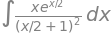

In [55]:
ex2 = ex.subs(a, R(1/2))
ex2

In [56]:
ex2.doit()

In [9]:
ex = sy.Integral((x**2 + a*x)*sy.cos(x), x)
ex

Integral((a*x + x**2)*cos(x), x)

In [10]:
ex.doit()

a*x*sin(x) + a*cos(x) + x**2*sin(x) + 2*x*cos(x) - 2*sin(x)

In [11]:
ex.subs(a,3).doit()

x**2*sin(x) + 3*x*sin(x) + 2*x*cos(x) - 2*sin(x) + 3*cos(x)

In [28]:
print(sy.latex(ex))

\frac{e^{a x}}{a^{3} x + a^{2}}


In [42]:
sympify("(E**(2*x))/(4*(2*x + 1)) + C", evaluate=False)

In [1]:
import aqt

In [2]:
mw = aqt.mw
col = mw.col

In [3]:
col.db.execute("""select * from sqlite_schema where name = 'revlog';""")

[['table',
  'revlog',
  'revlog',
  5,
  'CREATE TABLE revlog (\n  id integer PRIMARY KEY,\n  cid integer NOT NULL,\n  usn integer NOT NULL,\n  ease integer NOT NULL,\n  ivl integer NOT NULL,\n  lastIvl integer NOT NULL,\n  factor integer NOT NULL,\n  time integer NOT NULL,\n  type integer NOT NULL\n)']]

In [3]:
col.db.execute("""select * from revlog where cid = ?;""", 1672682213036)

[[1674612708719, 1672682213036, 16, 1, -60, -60, 0, 2733, 0],
 [1674847616643, 1672682213036, -1, 1, -60, -60, 0, 3223, 0],
 [1674847639190, 1672682213036, -1, 2, -330, -60, 0, 595, 0],
 [1674847646698, 1672682213036, -1, 2, -330, -60, 0, 389, 0],
 [1674847738362, 1672682213036, -1, 1, -60, -60, 0, 1264, 0],
 [1674847739533, 1672682213036, -1, 1, -60, -60, 0, 539, 0],
 [1674847740642, 1672682213036, -1, 1, -60, -60, 0, 486, 0]]

In [8]:
col.db.execute("""select id, cid, ease from revlog where cid = ? order by id desc;""", 1672682213036)

[[1674847740642, 1672682213036, 1],
 [1674847739533, 1672682213036, 1],
 [1674847738362, 1672682213036, 1],
 [1674847646698, 1672682213036, 2],
 [1674847639190, 1672682213036, 2],
 [1674847616643, 1672682213036, 1],
 [1674612708719, 1672682213036, 1]]

In [25]:
col.db.execute("""DROP INDEX IF EXISTS ix_revlog_cid_ease;""")

[]

In [19]:
col.db.execute("""CREATE INDEX IF NOT EXISTS ix_revlog_cid_ease ON revlog (cid, ease);""")

[]

In [4]:
cid = 1672682213036
rids = col.db.execute("""SELECT id FROM revlog WHERE cid = ? AND ease != 1 ORDER BY id DESC LIMIT 1;""", cid)
rids

[[1674847646698]]

In [7]:
cid = 1672682213036
success_buttons = [2,3,4]
rids = col.db.execute(f"""SELECT id FROM revlog WHERE cid = {cid} AND ease IN {tuple(success_buttons)} ORDER BY id DESC LIMIT 1;""")
rids

[[1674847646698]]

In [51]:
cid = 1672682252634
rids = col.db.execute("""SELECT id FROM revlog WHERE cid = ? AND ease != 1 ORDER BY id DESC LIMIT 1;""", cid)
rids

[]

In [55]:
rid = rids[0][0] if rids else ""
seed = rid or cid
rid, seed

(1674847646698, 1674847646698)

Some issues with logic for "toggle suspend" and "toggle bury" commands in browser cards menu:

- When multiple 

In [283]:
sy.integrate(sy.sqrt(4 - 9*x**2), (x, 0, R(2,3)))

pi/3